In [ ]:
# -*- coding: utf-8 -*-
# -*- author : Vincent Roduit - Fabio Palmisano -*-
# -*- date : 2024-01-20 -*-
# -*- Last revision: 2024-01-20 (Vincent Roduit)-*-
# -*- python version : 3.11.6 -*-
# -*- Description: Notebook that summarizes results-*-

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/EE-411-FOIL-Project/source

# <center> EE - 411: Fundamentals of Inference and Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Deep Double Descent: When Bigger Models and More Data Hurt </center>
---

In [ ]:
%load_ext autoreload
%autoreload 2

In [24]:
# Import librairies
import os
import torchvision

In [ ]:
# Import files
from training_utils import*
from functions import*
from display_functions import*
from data_utils import*
from data_classes import*

# 1. Introduction

## 1.1 Vizualize the Dataset

### 1.1.1 Define class dictionaries

In [19]:
#CIFAR-10
metadata_path = '../data/datasets/cifar-10-batches-py/batches.meta'
metadata = unpickle(metadata_path)
cifar10_dict = [label.decode('utf-8') for label in metadata[b'label_names']]

#CIFAR-100
metadata_path = '../data/datasets/cifar-100-python/meta'
metadata = unpickle(metadata_path)
cifar100_dict = [label.decode('utf-8') for label in metadata[b'fine_label_names']]

### 1.1.2 Vizualize Datasets

#### MNIST

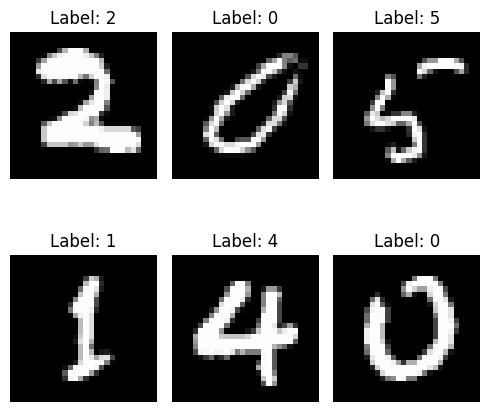

In [17]:
MNIST = NoisyMNIST()
visualize_dataset((np.array(MNIST.mnist.data), np.array(MNIST.mnist.targets)), num_images=6)

#### CIFAR 10

Files already downloaded and verified


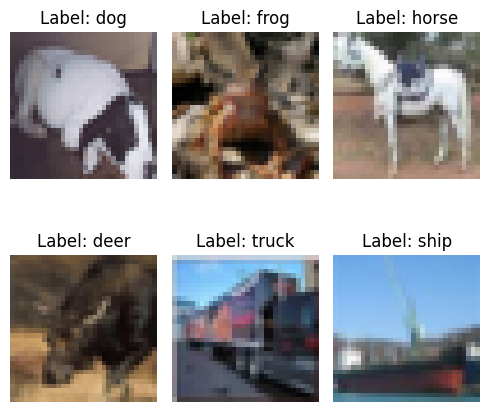

In [20]:
CIFAR10 = NoisyCIFAR10()
visualize_dataset((np.array(CIFAR10.cifar10.data), np.array(CIFAR10.cifar10.targets)), num_images=6,label_names=cifar10_dict)

#### CIFAR 100

Files already downloaded and verified


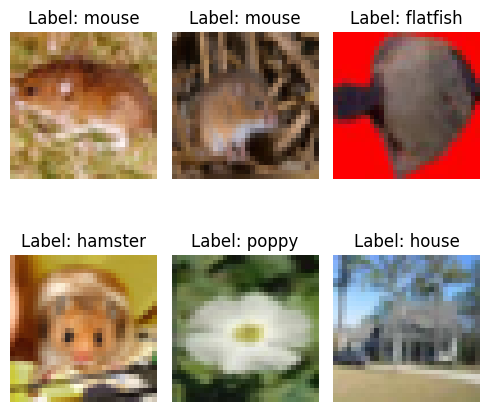

In [21]:
CIFAR100 = NoisyCIFAR100()
visualize_dataset((np.array(CIFAR100.cifar100.data), np.array(CIFAR100.cifar100.targets)), num_images=6,label_names=cifar100_dict)

### 1.2 Effect of transformation

#### 1.2.1 Horizontal Flip

Files already downloaded and verified


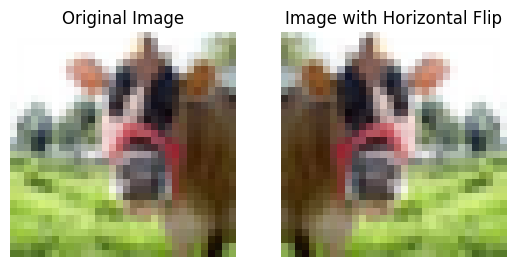

In [44]:
#Define transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Load CIFAR100 dataset
cifar100_dataset = torchvision.datasets.CIFAR100(root='../data/datasets', train=True, download=True, transform=transform)

#Random image
image1, _ = cifar100_dataset[0]
image2, _ = cifar100_dataset[1]

#Define RandomHorizontalFlip
horizontal_flip = torchvision.transforms.RandomHorizontalFlip(p=1)

#Apply RandomHorizontalFlip only to image1
image1_flip = horizontal_flip(image1)

#Plot images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image1.permute(1, 2, 0))
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(image1_flip.permute(1, 2, 0))
axes[1].set_title('Image with Horizontal Flip')
axes[1].axis('off')

plt.savefig(os.path.join(constants.RESULTS_FOLDER + 'horizontal_flip.png'))

plt.show()


#### Random Crop

Files already downloaded and verified


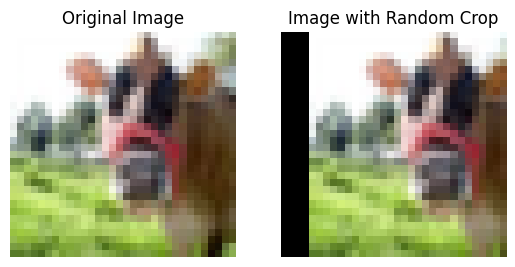

In [45]:
#Define transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Load CIFAR100 dataset
cifar100_dataset = torchvision.datasets.CIFAR100(root='../data/datasets', train=True, download=True, transform=transform)

#Random image
image1, _ = cifar100_dataset[0]
image2, _ = cifar100_dataset[1]

#Define RandomCrop
random_crop = torchvision.transforms.RandomCrop(size=32, padding=4)

#Apply RandomCrop only to image1
image1_crop = random_crop(image1)

#Plot images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image1.permute(1, 2, 0))
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(image1_crop.permute(1, 2, 0))
axes[1].set_title('Image with Random Crop')
axes[1].axis('off')

plt.savefig(os.path.join(constants.RESULTS_FOLDER + 'random_crop.png'))

plt.show()


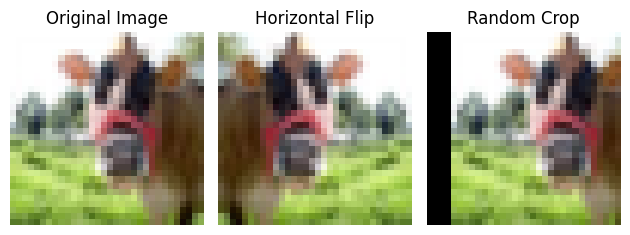

In [46]:
#Plot images
fig, axes = plt.subplots(1, 3)
axes[0].imshow(image1.permute(1, 2, 0))
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(image1_flip.permute(1, 2, 0))
axes[1].set_title('Horizontal Flip')
axes[1].axis('off')
axes[2].imshow(image1_crop.permute(1, 2, 0))
axes[2].set_title('Random Crop')
axes[2].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(constants.RESULTS_FOLDER + 'augmentations.png'))

# 2. Figure 4

## 2.1 MNIST

In [ ]:
width_model_list = np.linspace(1, 64, 30,dtype=int)
noise_ratio_list = [0,0.1,0.2]

In [ ]:
train_losses, train_accuracies, test_losses, test_accuracies = train_models(noise_ratio_list,
                                                                             width_model_list,
                                                                             optimizer='Adam', 
                                                                             model='ResNet',
                                                                             dataset_name='MNIST')

#### Obtain pre computed results stored as pickle files
As the computation of these figures is time expensive, results are stored in pickle format in order to plot without computing each time

In [ ]:
test_acc_sgd = open_pickle(os.path.join(constants.FIG6_FOLDER, 'test_accuracies_Adam.pkl'))
test_acc_adam = open_pickle(os.path.join(constants.FIG6_FOLDER, 'test_accuracies_SGD.pkl'))
test_error_sgd = (100 - np.array(test_acc_sgd)) / 100
test_error_adam = (100 - np.array(test_acc_adam)) / 100

display_optimizer_stats(test_error_adam,test_error_sgd,width_model_list)

In [ ]:
test_accuracies_path = os.path.join(constants.FIG4_FOLDER, 'test_acc.pkl')
test_accuracies = open_pickle(test_accuracies_path)
test_errors = (100 - np.array(test_accuracies)) / 100
display_error(error_lists=test_errors,width_model_list=width_model_list,noise_ratio_list=noise_ratio_list,train=False)

In [ ]:
train_accuracies_path = os.path.join(constants.FIG4_FOLDER, 'train_acc.pkl')
train_accuracies = open_pickle(test_accuracies_path)
train_errors = (100 - np.array(test_accuracies)) / 100
display_error(error_lists=train_errors,width_model_list=width_model_list,noise_ratio_list=noise_ratio_list,train=True)

## 3. Figure 6 : SGD vs Adam
5 Layer CNNs on CIFAR 10, no label noise, no data augmentation, using SGD for 500k gradient step, adam for 4K epochs

In [ ]:
#Parameters to test
width_model_list = np.linspace(1, 64, 20,dtype=int)
noise_ratio_list = [0.2]

In [ ]:
train_losses, train_accuracies, test_losses, test_accuracies = train_models(noise_ratio_list, 
                                                                            width_model_list,
                                                                            optimizer = 'Adam',
                                                                            model='CNN',
                                                                            dataset_name='CIFAR10')
train_losses_SGD, train_accuracies_SGD, test_losses_SGD, test_accuracies_SGD = train_models(noise_ratio_list, 
                                                                                            width_model_list,
                                                                                            optimizer = 'SGD',
                                                                                            model='CNN',
                                                                                            dataset_name='CIFAR10')

## 4. Further Experiments

#### 4.1 Test the convergence

In [ ]:
train_losses, test_losses,predictions = model_convergence(optimizer='Adam', model='ResNet',dataset_name='MNIST',num_epochs=10, noise_ratio=0.1, width=1)